In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

# Calibration
## Preparation of input data
This notebook prepares input data from the dataset "[Mobilität in Deutschland 2017](http://www.mobilitaet-in-deutschland.de/) B2" (MiD2017) for model calibration. The German Federal Ministry of Transport and Digital Infrastructure is copyright holder of this dataset and does not allow any form of publication.

In [3]:
input_path = '../input/'
zone_data_path = '../input_static/zones_Gebietsaenderungen/'
model_path = '../model/' + scenario + '/'
output_path = '../output/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

## Load survey data

And filter unspecified observations

In [5]:
cols = ['KKZ_SO', 'KKZ_ZO', 'VBGEM_SO', 'VBGEM_ZO', 'SKTYP', 'RegioStaR7',
        'wegkm_imp', 'km_routing_gr', 'wegmin_imp1',
        'hwzweck1', 'zweck', 'hvm_diff2', 'vm_kombi', 'anzpers',
        'auto', 'P_FKARTE', 'seg_vm',
        'bahn28', 'bus28', 'bahn28_zo', 'bus28_zo',
        'W_DETAIL', 'W_SO2', 'HP_ID_Reg', 'W_HOCH', 'W_GEW',
        'oek_status', 'anzauto_gr3', 'P_BIL', 'P_FS_PKW', 'vpedrad',
        'P_CS', 'pkwdicht_krs']
trips = pd.read_csv(input_path + 'transport_demand/MiD2017_Regional_Wege.csv',
                    sep=';', decimal=',', usecols=cols)[cols]
print(trips.shape)

(960619, 33)


In [6]:
trips.columns = ['o_nuts3', 'd_nuts3', 'origin', 'destination', 'SKTYP', 'RegioStaR7',
                 'distance', 'distance_routed', 'duration',
                 'purpose', 'purpose2', 'mode', 'mode_combo', 'n_persons',
                 'car_avail', 'ticket_type', 'mode_affinity',
                 'dist_train_origin', 'dist_bus_origin', 'dist_train_destination', 'dist_bus_destination',
                 'W_DETAIL', 'W_SO2', 'P_ID', 'W_HOCH', 'W_GEW',
                 'income_hh', 'cars_hh', 'education', 'license', 'bike_avail',
                 'car_sharing_abo', 'car_dens_zone']

In [7]:
# Number of persons in the survey
len(trips['P_ID'].unique())

259509

In [8]:
# Filter for trip details
trips = trips.loc[trips['W_DETAIL']!=0]
print(trips.shape)

(908497, 33)


In [9]:
# Filter for trips starting in Germany
trips = trips.loc[(trips['W_SO2']!=2) & (trips['W_SO2']!=3)]
print(trips.shape)

(907678, 33)


In [10]:
# Filter unspecified rows
trips = trips.loc[(trips['purpose']!=99) &
                  ~(trips['origin'].isin([7000000701, 999999995])) &
                  ~(trips['destination'].isin([7000000701, 999999995])) &
                  (trips['mode']<24) &
                  (trips['distance_routed']!=708) &
                  (trips['W_SO2']!=811)]
trips = trips.loc[(trips['origin']>1) &
                  (trips['destination']>1)]
print(trips.shape)

(417094, 33)


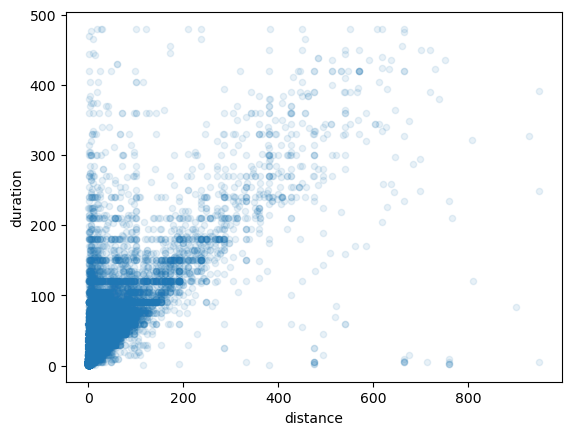

In [11]:
# Distance and duration are not plausible
if manual: trips.sample(100000).plot.scatter(x='distance', y='duration', alpha=.1)

In [12]:
# Filter for longer trips than 2km and 5min stated, because below that
# there are many unplausible observations
trips = trips.loc[trips['distance']>=2]
trips = trips.loc[trips['duration']>=5]
print(trips.shape)

(321620, 33)


In [13]:
# Remove ferries
trips = trips.loc[trips['mode']!=19]
print(trips.shape)

(321546, 33)


In [14]:
# How many zones are covered?
len(set(trips['origin']).union(set(trips['destination'])))

3296

### Translate columns to model values

In [15]:
# Make unknown number of persons equal to one
trips.loc[trips['n_persons']>6] = 1

In [16]:
trips = trips.loc[trips['origin']!=1] # pandas bug
len(trips)

320007

In [17]:
# Align regional specifics with urbanisation degree
urbanisation_dict = {1:1, 2:1, 3:2, 4:3}
trips['urbanisation'] = trips['SKTYP'].map(urbanisation_dict)

In [18]:
# Match trip purpose with demand segments of the model
purpose_mid_model_dict = {1: 'commuting', 2: 'business', 3: 'education',
                          4: 'shopping', 5: 'errands', 6: 'leisure',
                          7: 'accompany', 99: 'leisure'}
car_av_dict = {0: '_no_car', 1: '_car', 9: '_no_car'}
trips['purpose_model'] = trips['purpose'].map(purpose_mid_model_dict)
#trips['purpose_model'] = trips['purpose_model'] + trips['car_avail'].map(car_av_dict)

In [19]:
# Match mode with the model modes
# Non-motorised modes are merged
model_modes = {1: 'rail_short', 2: 'rail_long',
               3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mode_mid_vp_dict = {1:7, 2:7, 3:7, 4:6, 5:6, 6:6, 7:6, 8:6,
                    9:6, 10:6, 11:6, 12:4, 13:4, 14:4, 15:4,
                    16:1, 17:6, 18:6, 19:6, 20:2, 21:3, 22:3,
                    23:5, 24:6}
trips['mode_model'] = trips['mode'].map(mode_mid_vp_dict)

In [20]:
# Update ARS zone codes
# Load official data sources that describe changes
# in ARS codes within one year (Gebietsänderungen)
col_names = ['n', 'level', 'old_ARS', 'old_AGS', 'old_name',
             'change', 'area', 'population', 'new_ARS', 'new_AGS',
             'new_name', 'date1', 'date2']
def update_ARS_until(end, ars):
    for year in range(2016, end+1):
        changes = pd.read_excel(zone_data_path + str(year) + '.xlsx',
                                sheet_name='Gebietsaenderungen {}'.format(year),
                                header=6, skipfooter=8, index_col=None,
                                names=col_names, na_filter=False)
        changes = changes.loc[(changes['level']=='Gemeindeverband')
                              & (changes['old_ARS']!=changes['new_ARS'])]
        changes['old_ARS'] = changes['old_ARS'].astype(int)
        changes['new_ARS'] = changes['new_ARS'].astype(int)
        update_dict = changes.set_index('old_ARS')['new_ARS'].to_dict()
        ars = ars.replace(update_dict)
    return ars
trips['origin'] = update_ARS_until(2022, trips['origin'])
trips['destination'] = update_ARS_until(2022, trips['destination'])
assert len(trips.loc[trips.isna().any(axis=1)])==0

### Correct distances with model values

In [21]:
# Add model distances, as survey distances are not valid
# load and merge network model distances
od_lengths = pd.read_csv(output_path + 'distances_centroids.csv')
trips = trips.merge(od_lengths, how='left', on=['origin', 'destination'])

In [22]:
# Align with model OD set
trips = trips.loc[~((trips['length'].isna())&(trips['origin']!=trips['destination']))]
len(trips)

267612

In [23]:
# fill inner-zonal distances from survey distance
# if they make sense, else drop
trips = trips.loc[(trips['length'].notna()) |
                  ((trips['distance_routed'].isin(list(range(10)))) & (trips['distance']<30))]
trips.loc[trips['length'].isna(), 'length'] = trips.loc[trips['length'].isna(), 'distance']
len(trips)

256348

# Add zone specifics

POIs from OSM for different categories

In [24]:
# load model zones
z = stepmodel.read_json(model_path + 'de_zones')

In [25]:
# Add working places of destination zone
zone_dict = z.zones['employment'].to_dict()
trips['dest_employment'] = trips['destination'].map(zone_dict)
# Add inhabitants of destination zone
zone_dict = z.zones['population'].to_dict()
trips['dest_pop'] = trips['destination'].map(zone_dict)
# Add area of destination zone
zone_dict = z.zones['area'].to_dict()
trips['dest_area'] = trips['destination'].map(zone_dict)
# Add urbanisation of destination zone
zone_dict = z.zones['urbanisation'].to_dict()
trips['dest_urban'] = trips['destination'].map(zone_dict)

In [26]:
# Load zone-specific attraction attributes
attr = pd.read_csv(input_path + 'spatial_num_pois.csv', index_col=0)

In [27]:
# Add attraction attributes to trips
purpose_attr_dict = {3: 'education', 4: 'shopping', 6: 'leisure', 7: 'accompany'}
for p in [3, 4, 6]:
    for suffix in ['_many', '_few']:
        attr_dict = attr[purpose_attr_dict[p]+suffix].to_dict()
        trips['dest_'+purpose_attr_dict[p]+suffix] = trips['destination'].map(attr_dict)
attr_dict = attr[purpose_attr_dict[7]].to_dict()
trips['dest_'+purpose_attr_dict[7]] = trips['destination'].map(attr_dict)
assert len(trips.loc[trips.isna().any(axis=1)])==0

# Add cost and time

Based on the same rules as for the network model. Times for alternatives not chosen come from the LoS tables.

In [28]:
# Load LoS tables for times of all alternatives
pt = stepmodel.read_zippedpickles(model_path + 'de_pt_los')
car = stepmodel.read_zippedpickles(model_path + 'de_road_los')

car_los: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


In [29]:
# Make sure time is converted to minutes
if pt.pt_los['time'].mean() > 3000:
    pt.pt_los['time'] = pt.pt_los['time'] / 60
elif pt.pt_los['time'].mean() < 10:
    pt.pt_los['time'] = pt.pt_los['time'] * 60
if car.car_los['time'].mean() > 3000:
    car.car_los['time'] = car.car_los['time'] / 60
elif car.car_los['time'].mean() < 10:
    car.car_los['time'] = car.car_los['time'] * 60

In [30]:
# Init columns
car_modes = list(set(car.car_los['route_type']))
pt_modes = list(set(pt.pt_los['route_type']))
for m in car_modes + pt_modes:
    trips['time_'+m] = np.inf
    trips['cost_'+m] = np.inf

In [31]:
# Drop trips to destinations that are not in origins
trips = trips.loc[trips['destination'].isin(trips['origin'])]
len(trips)

256272

In [32]:
inner_mask = trips['origin']==trips['destination']

In [33]:
# Average access times to/from bus/train stops (mostly done by foot)
access_time = {1:1, 2:3, 3:6, 4:15, 5:45, 6:80, 95:np.nan, 701: np.nan}
# Compute RegioStaR7 means from trips with data
avg_time_bus = trips.loc[trips['dist_bus_origin']<7].groupby('RegioStaR7')['dist_bus_origin'].mean().round().astype(int)
avg_time_rail = trips.loc[trips['dist_train_origin']<7].groupby('RegioStaR7')['dist_train_origin'].mean().round().astype(int)
# Map trips to RegioStaR7 means for trips without data
regiostar_dict = trips.set_index('origin')['RegioStaR7'].to_dict()
avg_bus_origin = trips.loc[inner_mask, 'RegioStaR7'].map(avg_time_bus)
avg_bus_destination = trips.loc[inner_mask, 'destination'].map(regiostar_dict).map(avg_time_bus)
avg_rail_origin = trips.loc[inner_mask, 'RegioStaR7'].map(avg_time_rail)
avg_rail_destination = trips.loc[inner_mask, 'destination'].map(regiostar_dict).map(avg_time_rail)

### Inner-zonal time

In [34]:
# Inner-zonal bus
trips.loc[inner_mask, 'time_bus'] = trips.loc[inner_mask, 'length'] \
    / 18 * 60 \
    + trips.loc[inner_mask, 'dist_bus_origin'].map(access_time).fillna(avg_bus_origin) \
    + trips.loc[inner_mask, 'dist_bus_destination'].map(access_time).fillna(avg_bus_destination)

# Inner-zonal rail
trips.loc[inner_mask, 'time_rail_short'] = trips.loc[inner_mask, 'length'] \
    / 50 * 60 \
    + trips.loc[inner_mask, 'dist_train_origin'].map(access_time).fillna(avg_rail_origin) \
    + trips.loc[inner_mask, 'dist_train_destination'].map(access_time).fillna(avg_rail_destination)

# Inner-zonal non-motorised
trips.loc[inner_mask, 'time_walk'] = trips.loc[inner_mask, 'length'] / \
    params['pt_access']['speed_bicycle'] * 60

# Inner-zonal car
urbs = set(z.zones['urbanisation'])
park_time = dict(zip(range(1, len(urbs)+1), [params['access-egress_links']['time_road_'+str(u)]/60 for u in urbs]))
trips.loc[inner_mask, 'time_car'] = trips.loc[inner_mask, 'length'] \
    / params['pt_access']['speed_car'] * 60 \
    + trips.loc[inner_mask, 'dest_urban'].map(park_time)

### Inter-zonal time

In [35]:
# Car
car_dict = car.car_los.groupby(['origin', 'destination'])['time'].min().to_dict()
trips.loc[~inner_mask, 'time_car'] = [car_dict[a] if a in car_dict.keys() else np.nan
                                      for a in tuple(zip(trips.loc[~inner_mask, 'origin'].astype(str),
                                                         trips.loc[~inner_mask, 'destination'].astype(str)))]
# All OD pairs should be in the model
trips = trips.loc[~trips['time_car'].isna()]
len(trips)

256135

In [36]:
# PT (incl. bicycle)
pt_dict = pt.pt_los.groupby(['origin', 'destination', 'route_type'])['time'].min().to_dict()
for t in pt.pt_los['route_type'].unique():
    trips['route_type'] = t
    trips.loc[~inner_mask, 'time_' + t] = [pt_dict[a]
                                           if a in pt_dict.keys() else np.inf
                                           for a in tuple(zip(trips.loc[~inner_mask, 'origin'],
                                                              trips.loc[~inner_mask, 'destination'],
                                                              trips.loc[~inner_mask, 'route_type']))]
trips.drop('route_type', axis=1, inplace=True)

In [37]:
# How many observations have no connection in the PT model?
print("Looking at coverage of inter-zonal observations' mode choices")
for i,t in model_modes.items():
    try:
        k = len(trips.loc[(trips['mode_model']==i) & (trips['time_'+t]==np.inf) & ~inner_mask])
        print('{}: {} without model connection ({} percent)'.format(
            t, k, round(k/len(trips.loc[trips['mode_model']==i])*100, 1)))
    except ZeroDivisionError:
        print('{} mode has no observations'.format(t))

Looking at coverage of inter-zonal observations' mode choices
rail_short: 139 without model connection (1.4 percent)
rail_long: 80 without model connection (15.7 percent)
coach: 157 without model connection (35.6 percent)
bus: 1014 without model connection (3.7 percent)
air: 16 without model connection (69.6 percent)
car: 0 without model connection (0.0 percent)
walk: 241 without model connection (25.4 percent)


In [38]:
# Analysis shows that rail long- and short- distance were confused in many observations
# --> correct the mode choice
trips.loc[((trips['time_rail_short']==np.inf)
           & (trips['time_rail_long']!=np.inf)
           & (trips['mode_model']==1)), 'mode_model'] = 2
trips.loc[((trips['time_rail_long']==np.inf)
           & (trips['time_rail_short']!=np.inf)
           & (trips['mode_model']==2)), 'mode_model'] = 1
# Equally for public road
trips.loc[((trips['time_bus']==np.inf)
           & (trips['time_coach']!=np.inf)
           & (trips['mode_model']==4)), 'mode_model'] = 3
trips.loc[((trips['time_coach']==np.inf)
           & (trips['time_bus']!=np.inf)
           & (trips['mode_model']==3)), 'mode_model'] = 4

In [39]:
print('Coverage of inter-zonal mode choice after correction')
for i,t in model_modes.items():
    try:
        k = len(trips.loc[(trips['mode_model']==i) & (trips['time_'+t]==np.inf) & ~inner_mask])
        print('{}: {} without model connection ({} percent)'.format(
            t, k, round(k/len(trips.loc[trips['mode_model']==i])*100, 1)))
    except ZeroDivisionError:
        print('{} mode has no observations'.format(t))

Coverage of inter-zonal mode choice after correction
rail_short: 106 without model connection (1.0 percent)
rail_long: 6 without model connection (1.3 percent)
coach: 19 without model connection (3.6 percent)
bus: 555 without model connection (2.0 percent)
air: 16 without model connection (69.6 percent)
car: 0 without model connection (0.0 percent)
walk: 241 without model connection (25.4 percent)


In [40]:
# Replace non-existent air connections with random model paths
for ind in trips.loc[(trips['mode_model']==5) & (trips['time_air']==np.inf)].index:
    i = 0
    while i < 10:
        s = pt.pt_los.loc[pt.pt_los['route_type']=='air'].sample()
        o = s['origin'].values[0]
        d = s['destination'].values[0]
        try:
            _ = car_dict[(str(o),str(d))]
            i = 10
        except KeyError:
            i += 1
    trips.loc[ind, 'origin'] = o
    trips.loc[ind, 'destination'] = d
    trips.loc[ind, 'urbanisation'] = z.zones.loc[o, 'urbanisation']
    trips.loc[ind, 'length'] = s['length'].values[0] / 1000
    trips.loc[ind, 'time_air'] = s['time'].values[0]
    trips.loc[ind, 'time_car'] = car_dict[(str(o),str(d))]
    trips.loc[ind, 'time_walk'] = pt_dict[(o,d,'walk')] if (o,d,'walk') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_rail_short'] = pt_dict[(o,d,'rail_short')] if (o,d,'rail_short') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_rail_long'] = pt_dict[(o,d,'rail_long')] if (o,d,'rail_long') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_bus'] = pt_dict[(o,d,'bus')] if (o,d,'bus') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_coach'] = pt_dict[(o,d,'coach')] if (o,d,'coach') in pt_dict.keys() else np.inf

In [41]:
# Drop missing trips
for i, mode in model_modes.items():
    trips = trips.loc[~((trips['mode_model']==i) & (trips['time_'+mode]==np.inf))]
len(trips)

255208

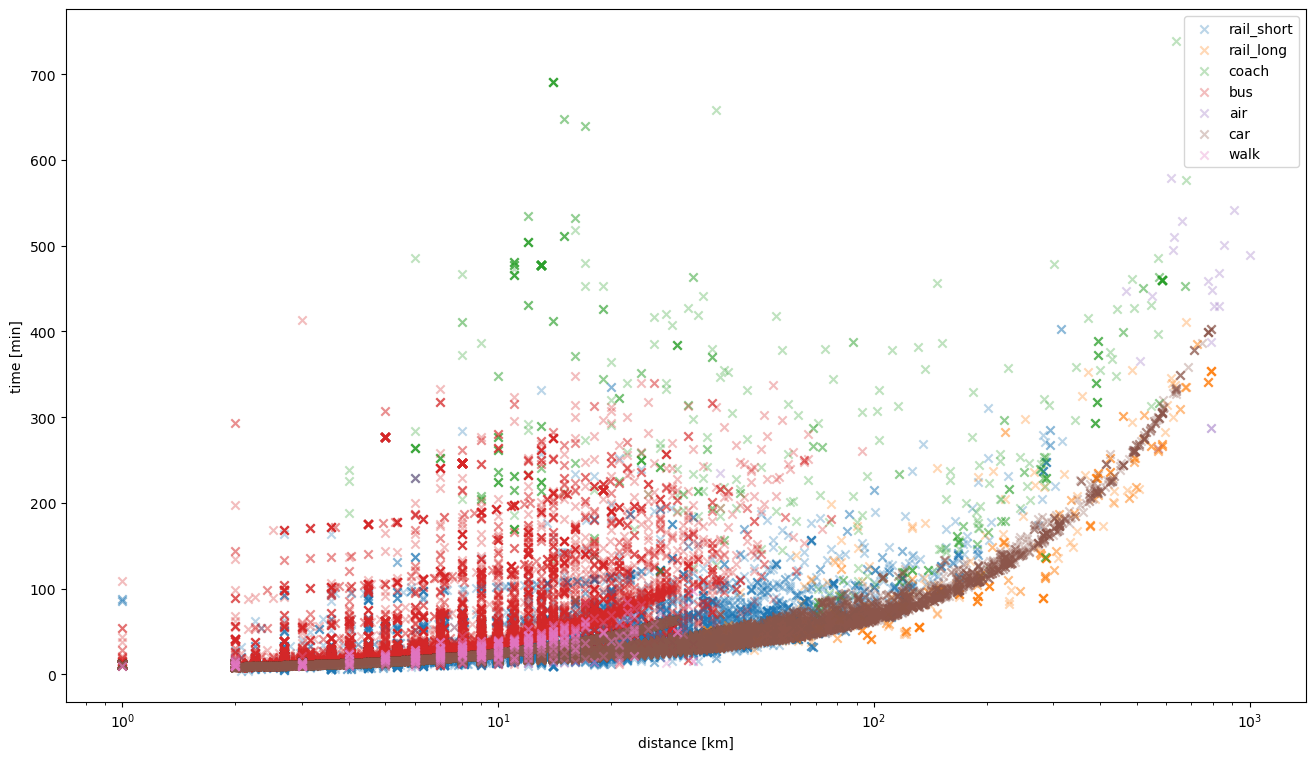

In [42]:
# Show durations of the mode chosen
if manual:
    fig, ax = plt.subplots(figsize=(16,9))
    for i, m in model_modes.items():
        t = trips.loc[trips['mode_model']==i]
        plt.scatter(t['length'], t['time_'+m], marker='x', alpha=.3, label=m, zorder=i)
    plt.legend()
    ax.set_xscale('log')
    ax.set_xlabel('distance [km]')
    ax.set_ylabel('time [min]')

In [43]:
# Drop outliers
for i, m in model_modes.items():
    trips = trips.loc[~((trips['mode_model']==i) & (trips['time_'+m]>300) & (trips['length']<100))]
len(trips)

255025

### Prices

In [44]:
# Non-motorised
trips['cost_walk'] = 0

# Car: The same assumptions for car travel as in the car LoS table (prep31)
vc_car = params['car_var_cost'].to_dict() # €/km
fix_car = params['car_fix_cost'].to_dict() # €/h
parking_cost = params['parking_cost'].to_dict()
car_av = ['_no_car', '_car']
trips['cost_car'] = [(d * vc_car[p+car_av[car]] + parking_cost[u]) / n + fix_car[p+car_av[car]] * t/60
                     for d, n, u, t, p, car in zip(trips['length'], trips['n_persons'],
                                                   trips['urbanisation'], trips['time_car'],
                                                   trips['purpose_model'], trips['car_avail'].replace({9:0})
                                                   )]
# Rail short-distance / regional
# Ticket type determines the trip cost
# Assume this dict with factors
ticket_dict = {1:1, 2:0.9, 3:0.5, 4:0, 5:0, 6:1, 7:1, 99:1, 200:1}
rail_short_slope = params['rail_short']['slope']
rail_short_intercept = params['rail_short']['intercept']
trips['cost_rail_short'] = [(d*rail_short_slope + rail_short_intercept) * ticket_dict[t]
                            for d, t in zip(trips['length'], trips['ticket_type'])]
# Add price cap
trips['cost_rail_short'] = np.clip(trips['cost_rail_short'], 0, params['rail_short']['max'])

# Bus and tram
# Trip cost depend on the ticket type and regional type
# See prep31 for prices
region_prices = params['bus'].to_dict()
trips['cost_bus'] = [region_prices[r] * ticket_dict[t]
                     for r,t in zip(trips['urbanisation'], trips['ticket_type'])]

In [50]:
# Long-distance PT from network model
# Rail long-distance
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
car_str = ['_no_car', '_car']
rail_dict = pt.pt_los.loc[pt.pt_los['route_type']=='rail_long'].sort_values('time').groupby(
    ['origin', 'destination']).agg({seg+'_price': 'mean' for seg in segments}).to_dict()
trips['cost_rail_long'] = [rail_dict[p+car_str[car]+'_price'][(o,d)]
                           if (o,d) in rail_dict[p+car_str[car]+'_price'].keys() else np.inf
                           for o, d, p, car in zip(trips['origin'], trips['destination'],
                                                   trips['purpose_model'], trips['car_avail']==1)]

# Coach (see prep31)
trips['cost_coach'] = trips['length'] * params['coach']['slope']
trips['cost_coach'] = np.clip(trips['cost_coach'], params['coach']['min'], params['coach']['max'])

# Air
air_dict = pt.pt_los.loc[pt.pt_los['route_type']=='air'].sort_values('time').groupby(
    ['origin', 'destination']).agg({seg+'_price': 'mean' for seg in segments}).to_dict()
trips['cost_air'] = [air_dict[p+car_str[car]+'_price'][(o,d)]
                     if (o,d) in air_dict[p+car_str[car]+'_price'].keys() else np.inf
                     for o, d, p, car in zip(trips['origin'], trips['destination'],
                                             trips['purpose_model'], trips['car_avail']==1)]
trips.loc[trips['cost_air'].isna(), 'cost_air'] = np.inf

In [51]:
assert len(trips.loc[trips.isna().any(axis=1)])==0

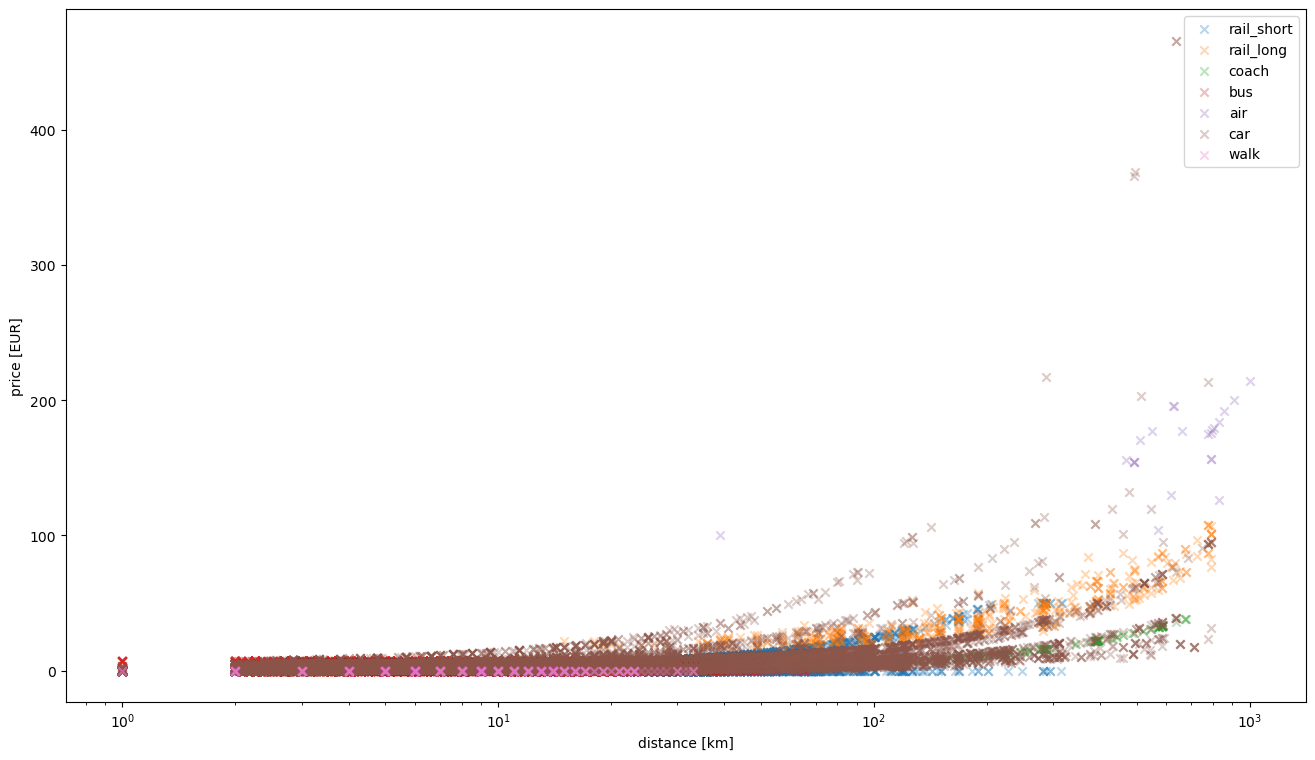

In [54]:
# Show prices of the mode chosen
if manual:
    fig, ax = plt.subplots(figsize=(16,9))
    for i, m in model_modes.items():
        t = trips.loc[trips['mode_model']==i]
        plt.scatter(t['length'], t['cost_'+m], marker='x', alpha=.3, label=m, zorder=i)
    plt.legend()
    ax.set_xscale('log')
    ax.set_xlabel('distance [km]')
    ax.set_ylabel('price [EUR]')

In [58]:
# Drop outliers
trips = trips.loc[trips['cost_car']<100]
len(trips)

254876

# Save dataset

Save one dataset to be used in all estimations of the joint demand model

<Axes: title={'center': 'Sample size by trip purpose'}, xlabel='purpose_model'>

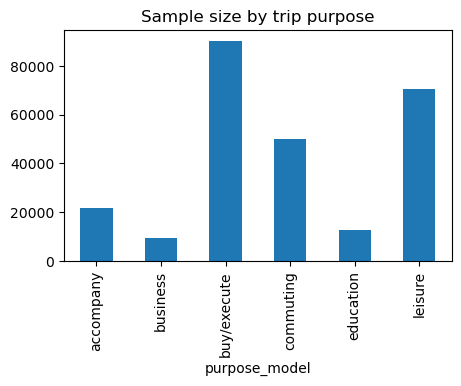

In [59]:
# Sample size per trip purpose
trips.groupby('purpose_model').size().plot.bar(
    figsize=(5, 3), title='Sample size by trip purpose',
    legend=False)

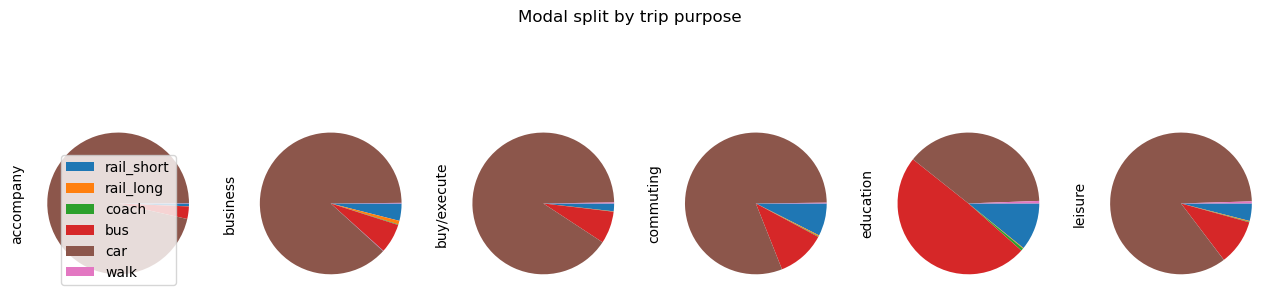

In [60]:
# Modal split
axs = trips.groupby(['mode_model','purpose_model']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 4), labels=[m for _, m in model_modes.items()],
    startangle=0, counterclock=False, title='Modal split by trip purpose',
    legend=False, labeldistance=None)
axs[0].legend()

<Axes: title={'center': 'Trip distance distribution, logarithmic'}, ylabel='Frequency'>

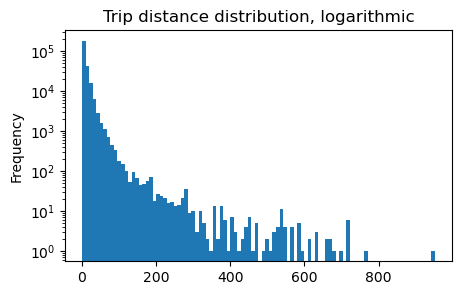

In [61]:
# Trip distance
trips['distance'].plot.hist(bins=100, log=True, figsize=(5,3),
                            title='Trip distance distribution, logarithmic')

<Axes: title={'center': 'Sample size by RegioStaR7 home location'}, xlabel='RegioStaR7'>

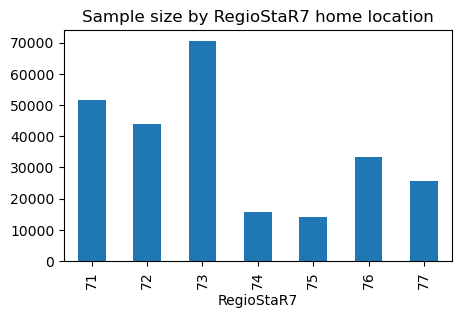

In [62]:
# Sample size per origin type
trips.groupby('RegioStaR7').size().plot.bar(
    figsize=(5, 3), title='Sample size by RegioStaR7 home location',
    legend=False)

In [63]:
trips.to_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv')

In [ ]:
#trips.loc[trips['origin']!=trips['destination']
#         ].groupby(['mode_model', 'purpose_model'])['origin'].count().unstack().fillna(0)\
#    .to_csv('../input_static/mid2017_validation_normalised.csv')